# NNs in Sklearn

## Classification
Check out the documentation for the MLPClassifier: [link to MLPClassifier documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

# Read Data

In [ ]:
import warnings
warnings.filterwarnings("ignore")  # keep output tidy; MLP may warn about convergence

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = fetch_california_housing(as_frame=True)
X = data.frame.drop(columns=["MedHouseVal"])
y_cont = data.frame["MedHouseVal"]

## Recode to classification problem
Recode target to 0/1 via 75th percentile threshold.

In [ ]:
threshold = y_cont.quantile(0.75)
y = (y_cont > threshold).astype(int)

print(f"75th percentile threshold for MedHouseVal: {threshold:.3f}")
print(f"Class balance (0/1): {(y.value_counts().sort_index().to_dict())}")

75th percentile threshold for MedHouseVal: 2.647
Class balance (0/1): {0: 15480, 1: 5160}


# Train, val, test split

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Scale Features

In [ ]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# 🔵 Fit the model

In [ ]:
clf = MLPClassifier(random_state=42)  # defaults: hidden_layer_sizes=(100,), max_iter=200, etc.
clf.fit(X_train_s, y_train)

MLPClassifier(random_state=42)

In [ ]:
clf = MLPClassifier(random_state=42,
                   hidden_layer_sizes=(5,5),
                   max_iter=200,
                   batch_size=10,
                   activation="relu",
                   validation_fraction=0.2,
                   early_stopping=True) # important!
clf.fit(X_train_s, y_train)

MLPClassifier(batch_size=10, early_stopping=True, hidden_layer_sizes=(5, 5),
              random_state=42, validation_fraction=0.2)

### 🔴 Knobs you can turn

Play with the activation functions.

```python
activation="relu"      # default & best baseline
activation="tanh"      # smoother, symmetric
activation="logistic"  # sigmoid (rarely ideal)
activation="identity"  # turns NN into linear regression
```

How many layers should I use and what are their sizes? I think `size_of_hidden_layer` = `n_columns` OR 2*`n_columns`... don't go  bananas!

How many layers should I use? Just try 1, 2 or 3 to start... less is often more!

```python
hidden_layer_sizes=(50,)
hidden_layer_sizes=(30, 30)
hidden_layer_sizes=(50, 20, 10)
```

Batch size... how many records does it look at per epoch?

```python
batch_size=32     # mini-batch
batch_size=128
batch_size="auto" # default
```

### 🔴 Loss Curve (training only, default for sklearn)

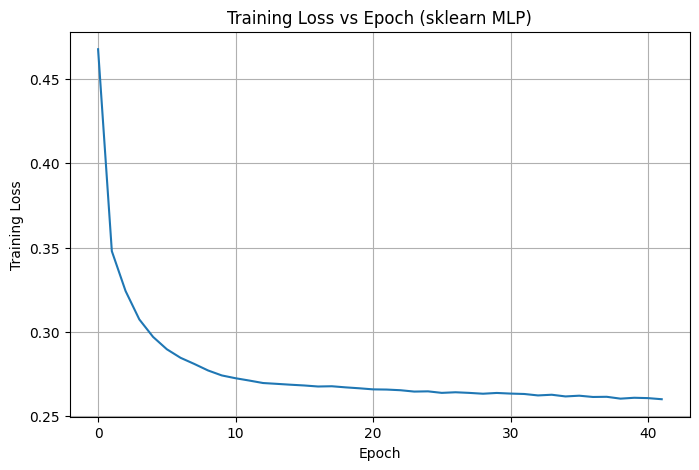

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(clf.loss_curve_)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch (sklearn MLP)")
plt.grid(True)
plt.show()

**Figure 1:** Loss curve for MLPClassifier (loss is distance between categories... it's different for classification... a more 'confident' model has a lower loss than a less confident one. For example, do you want 10/90 fitted predictions or 49/51 as the decision boundary? More confident is more desirable.)

# Predict
Store in dictionary for easy handling.

In [ ]:
# 6) Predictions
preds = {
    "train": clf.predict(X_train_s),
    "val":   clf.predict(X_val_s),
    "test":  clf.predict(X_test_s),
}
truth = {
    "train": y_train.values,
    "val":   y_val.values,
    "test":  y_test.values,
}

# Results

In [ ]:
def pretty_classification_report(y_true, y_pred):
    rpt = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    df = pd.DataFrame(rpt).transpose()
    # Clean up column names and order
    cols = ["precision", "recall", "f1-score", "support"]
    df = df[cols]
    return df

def pretty_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    df = pd.DataFrame(cm, index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"])
    return df

### Show results

In [ ]:
for split in ["train", "val", "test"]:
    y_true = truth[split]
    y_pred = preds[split]
    print("\n" + "="*70)
    print(f"{split.upper()} RESULTS")
    print("="*70)
    print("\nClassification Report")
    print(pretty_classification_report(y_true, y_pred).round(3).to_string())
    print("\nConfusion Matrix")
    print(pretty_confusion_matrix(y_true, y_pred).to_string())


TRAIN RESULTS

Classification Report
              precision  recall  f1-score    support
0                 0.913   0.942     0.927  12384.000
1                 0.808   0.732     0.768   4128.000
accuracy          0.889   0.889     0.889      0.889
macro avg         0.860   0.837     0.848  16512.000
weighted avg      0.887   0.889     0.888  16512.000

Confusion Matrix
          Pred 0  Pred 1
Actual 0   11664     720
Actual 1    1106    3022

VAL RESULTS

Classification Report
              precision  recall  f1-score   support
0                 0.910   0.937     0.923  1548.000
1                 0.793   0.721     0.755   516.000
accuracy          0.883   0.883     0.883     0.883
macro avg         0.851   0.829     0.839  2064.000
weighted avg      0.881   0.883     0.881  2064.000

Confusion Matrix
          Pred 0  Pred 1
Actual 0    1451      97
Actual 1     144     372

TEST RESULTS

Classification Report
              precision  recall  f1-score   support
0                 0.9

## As heatmaps

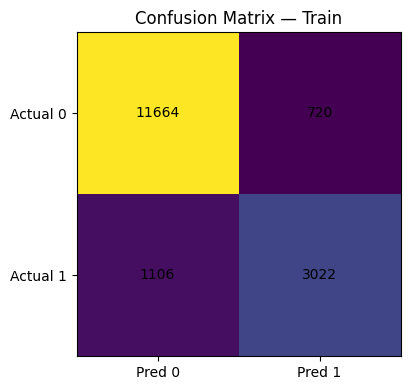

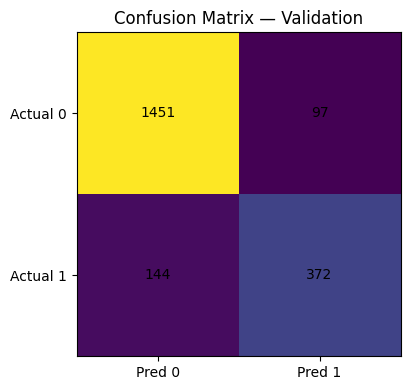

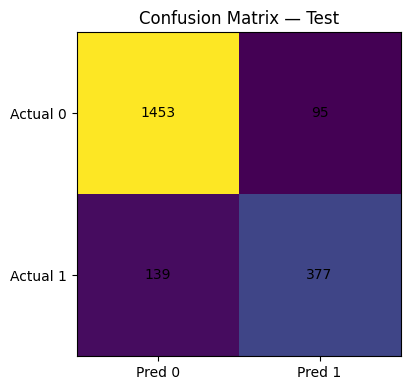

In [ ]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    plt.figure(figsize=(4.5,4))
    plt.imshow(cm)
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.xticks([0,1], ["Pred 0","Pred 1"])
    plt.yticks([0,1], ["Actual 0","Actual 1"])
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_cm(truth["train"], preds["train"], "Confusion Matrix — Train")
plot_cm(truth["val"],   preds["val"],   "Confusion Matrix — Validation")
plot_cm(truth["test"],  preds["test"],  "Confusion Matrix — Test")


**Figure 2:** Colored confusion matrices by partition.